# Replicate Paper Results: 1D and 2D Spectroscopy Data Processing

This notebook loads and plots both 1D and 2D spectroscopy data from pickle files to replicate paper results.

# Generalized Functions for Data Loading

In [1]:
# =============================
# IMPORTS
# =============================
import os
import sys
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Project-specific imports
from config.paths import DATA_DIR, FIGURES_DIR
from src.spectroscopy.post_processing import extend_and_plot_results
from src.visualization.plotting import Plot_2d_El_field, Plot_fixed_tau_T
from src.visualization import mpl_tex_settings

In [2]:
# =============================
# GENERALIZED DATA LOADING FUNCTIONS
# =============================

def find_latest_file(data_subdir: str, file_pattern: str = "*.pkl") -> Path:
    """Find the most recent file matching pattern in a data subdirectory.
    
    Args:
        data_subdir: Subdirectory within DATA_DIR (e.g., '1d_spectroscopy', 'raw/2d_spectroscopy')
        file_pattern: Glob pattern for file matching
    
    Returns:
        Path to the latest file or None if not found
    """
    data_dir = DATA_DIR / data_subdir
    
    if not data_dir.exists():
        print(f"❌ Data directory does not exist: {data_dir}")
        return None
    
    # Look for files matching the pattern
    files = list(data_dir.glob(file_pattern))
    
    # For 2D data, also look for compressed files
    if "2d_spectroscopy" in data_subdir:
        files.extend(list(data_dir.glob("*.pkl.gz")))
    
    if not files:
        print(f"❌ No files matching '{file_pattern}' found in {data_dir}")
        return None
    
    # Get the most recent file
    latest_file = max(files, key=lambda p: p.stat().st_mtime)
    print(f"✅ Found latest file: {latest_file.name}")
    return latest_file


def load_pickle_file(filepath: Path) -> dict:
    """Load data from pickle file (supports both .pkl and .pkl.gz).
    
    Args:
        filepath: Path to the pickle file
    
    Returns:
        Dictionary containing the loaded data or None if error
    """
    print(f"Loading data from: {filepath.name}")
    
    try:
        if filepath.suffix == ".gz":
            # Handle compressed pickle files
            with gzip.open(filepath, "rb") as f:
                data = pickle.load(f)
        else:
            # Handle regular pickle files
            with open(filepath, "rb") as f:
                data = pickle.load(f)
        
        print(f"✅ Data loaded successfully!")
        return data
    
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None


def create_output_directory(subdir: str) -> Path:
    """Create output directory for figures.
    
    Args:
        subdir: Subdirectory name within FIGURES_DIR
    
    Returns:
        Path to the created output directory
    """
    output_dir = FIGURES_DIR / subdir
    os.makedirs(output_dir, exist_ok=True)
    return output_dir


# 1. Process 1D Spectroscopy Data (Fixed τ, T)

✅ Found latest file: 1d_data_averaged_500.pkl
Loading data from: 1d_data_averaged_500.pkl
✅ Data loaded successfully!
  τ_coh = 300.00 fs
  T_wait = 1000.00 fs
  t_det_vals: 301 points from 0.00 to 600.00 fs
  data_avg shape: (301,)
  ω_ats: 50 frequencies
  System parameters: SystemParameters(hbar=1.0, Boltzmann=1.0, atom_g=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]], atom_e=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]], Temp=1.0, cutoff_=1.0, N_atoms=1, ODE_Solver='Paper_eqs', RWA_laser=True, E0=0.005, pulse_FWHM=15.0, t_max=1900.0, dt=2.0, envelope_type='gaussian', omega_laser_cm=16000.0, Delta_cm=200, omega_A_cm=16915.985911257605, omega_B_cm=None, mu_A=1.0, mu_B=None, J_cm=None, gamma_0=0.0033333333333333335, gamma_phi=0.01, psi_ini=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]])
📊 Generating 1D spectroscopy plot

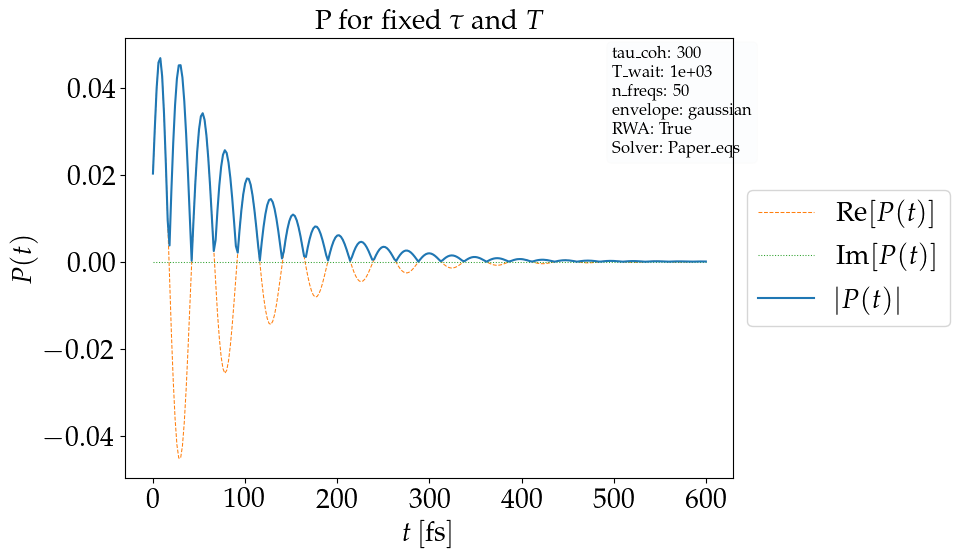

✅ 1D plot completed!


In [3]:
# =============================
# LOAD AND PLOT 1D SPECTROSCOPY DATA
# =============================

### Find and load 1D data
file_path_1d = find_latest_file("1d_spectroscopy", "1d_data_averaged_500*.pkl")

if file_path_1d is not None:
    loaded_data = load_pickle_file(file_path_1d)
    
    if loaded_data is not None:
        # Extract 1D data
        t_det_vals = loaded_data['t_det_vals']
        data_avg   = loaded_data['data_avg']
        tau_coh    = loaded_data['tau_coh']
        T_wait     = loaded_data['T_wait']
        system     = loaded_data['system']
        n_freqs  = loaded_data['n_freqs']
        
        ### Display data information
        print(f"  τ_coh = {tau_coh:.2f} fs")
        print(f"  T_wait = {T_wait:.2f} fs")
        print(f"  t_det_vals: {len(t_det_vals)} points from {t_det_vals[0]:.2f} to {t_det_vals[-1]:.2f} fs")
        print(f"  data_avg shape: {data_avg.shape}")
        print(f"  ω_ats: {n_freqs} frequencies")
        print(f"  System parameters: {system}")
        
        ### Prepare plotting arguments
        kwargs = {
            'tau_coh': tau_coh,
            'T_wait': T_wait,
            'n_freqs': n_freqs,
            'envelope': system.envelope_type,
            'RWA': system.RWA_laser,
            'Solver': system.ODE_Solver,
        }
        
        ### Generate 1D plot
        print("📊 Generating 1D spectroscopy plot...")
        Plot_fixed_tau_T(t_det_vals, data_avg, **kwargs)
        print("✅ 1D plot completed!")
        
    else:
        print("❌ Failed to load 1D spectroscopy data.")
else:
    print("   Please run the 1D spectroscopy calculation first to generate data.")


# 2. Process 2D Spectroscopy Data

In [4]:
# =============================
# LOAD AND PLOT 2D SPECTROSCOPY DATA
# =============================

### Find and load 2D data
file_path_2d = find_latest_file("2d_spectroscopy", "*.pkl")

if file_path_2d is not None:
    loaded_data = load_pickle_file(file_path_2d)
    
    if loaded_data is not None:
        # Extract 2D data
        two_d_datas = loaded_data["two_d_datas"]
        times_T     = loaded_data["times_T"]
        times       = loaded_data["times"]
        system_data = loaded_data["system"]
        
        ### Display data information
        print(f"  Loaded {len(two_d_datas)} 2D datasets")
        print(f"  System data: {system_data}")
        
        ### Create output directory
        output_dir = create_output_directory("2d_spectroscopy")
        
        ### Plot each component type
        plot_types = ["imag", "real", "abs", "phase"]
        
        for plot_type in plot_types:
            print(f"📊 Plotting {plot_type} component...")
            
            plot_args = {
                "domain": "freq",
                "type": plot_type,
                "save": True,
                "output_dir": output_dir,
                "use_custom_colormap": True,
                # "section": (1, 2, 1, 2),  # Plot the first section
                "system": system_data,
            }
            
            try:
                extend_and_plot_results(
                    two_d_datas,
                    times_T=times_T,
                    times=times,
                    **plot_args,
                )
                plt.close("all")  # Clean up matplotlib figures
                print(f"✅ {plot_type} plot completed!")
                
            except Exception as e:
                print(f"❌ Error plotting {plot_type}: {e}")
        
        print(f"🎯 All 2D plots saved to: {output_dir}")
        
    else:
        print("❌ Failed to load 2D spectroscopy data.")
else:
    print("   Please run the 2D spectroscopy calculation first to generate data.")

✅ Found latest file: 2d_data_tmax_5_dt_0.1_T1_ph2_freq1_20250604_162742.pkl
Loading data from: 2d_data_tmax_5_dt_0.1_T1_ph2_freq1_20250604_162742.pkl
✅ Data loaded successfully!
  Loaded 1 2D datasets
  System data: SystemParameters(hbar=1.0, Boltzmann=1.0, atom_g=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]], atom_e=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]], Temp=1.0, cutoff_=1.0, N_atoms=1, ODE_Solver='Paper_eqs', RWA_laser=True, E0=0.05, pulse_FWHM=15.0, t_max=5.0, dt=0.1, envelope_type='gaussian', omega_laser_cm=16000.0, Delta_cm=0, omega_A_cm=16000.0, omega_B_cm=None, mu_A=1.0, mu_B=None, J_cm=None, gamma_0=0.0033333333333333335, gamma_phi=0.01, psi_ini=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]])
📊 Plotting imag component...
❌ Error plotting imag: tuple index out of range
📊 Plotting real component...
❌ Erro